In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import uuid
import math

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

from scipy.ndimage.measurements import label

Using TensorFlow backend.


In [2]:
def testAugmentation(img_src):
    datagen = ImageDataGenerator(
            rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    img = load_img(img_src)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely

In [3]:
def train_model():
    # dimensions of our images.
    img_width, img_height = 128, 128

    train_data_dir = 'data/train'
    validation_data_dir = 'data/validation'
    nb_train_samples = 2000
    nb_validation_samples = 800
    epochs = 2
    batch_size = 16

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    # this is the augmentation configuration we will use for training
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    # this is the augmentation configuration we will use for testing:
    # only rescaling
    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

    model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

    model.save_weights('first_try.h5')
    
    return model

In [4]:
def test_model():
    img = image.load_img('test_data/a1.JPG', target_size=(img_width, img_height))
    x = image.img_to_array(img)
    # x = np.expand_dims(x, axis=0)
    x = np.array([x])
    x = preprocess_input(x)

    preds = model.predict(x)

    print(preds[0])
    plt.imshow(img)
    plt.show() 

# Heat map

In [5]:
def addHeatMap(image, box_list):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    heat = add_heat(heat, box_list)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img
    
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Sliding windows

In [6]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img1, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    img = np.copy(img1)
    
    # fix when there is no mach between count of windows and image shape 
    # window: (33,33) image(100,100)
    if(xy_overlap[0] > 0):
        width = img.shape[0]
        length = img.shape[1]
        
        a = math.ceil(img.shape[0] / (xy_window[0]*xy_overlap[0])) * (xy_window[0]*xy_overlap[0])
        b = math.ceil(img.shape[1] / (xy_window[1]*xy_overlap[1])) * (xy_window[1]*xy_overlap[1])
        
        img = cv2.resize(img1, (int(b), int(a)))
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list, img # fixed resized window

In [7]:
def slide_window_scale(img, scales, xy_window):
    windows_all = []
    for scale in scales:
        resized_img = cv2.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))
        windows, resized_fixed_img = slide_window(resized_img, xy_window=xy_window)
        for window in windows:
            windows_all.append(window)            
            cv2.rectangle(resized_fixed_img, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
        plt.imshow(resized_fixed_img)
        plt.show() 
        
    return windows_all
        

## Pipeline

In [15]:
def pipeline_vision(model, image_src, xy_window = (128, 128), scales = [2]):
    img = mpimg.imread(image_src)
    plt.imshow(img)
    plt.show()

    windows = slide_window_scale(img, scales, xy_window)
    print(len(windows))   

    hot_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], xy_window)      

        x = image.img_to_array(test_img)
        x = np.array([x])
        x = preprocess_input(x)
        preds = model.predict(x)

        # arrow
        if(preds[0]==0):        
            hot_windows.append(((window[0][0], window[0][1]), (window[1][0], window[1][1])))

            #mpimg.imsave("prediction/" + uuid.uuid4().hex + ".png", test_img)
            #plt.imshow(test_img)
            #plt.show()

    draw_img3 = addHeatMap(img, hot_windows)
    plt.imshow(draw_img3)
    plt.show()

In [21]:
def pipeline_vision_single(model, image_src, xy_window = (128, 128), scale = 2):
    img = mpimg.imread(image_src)
    plt.imshow(img)
    plt.show()

    img = cv2.resize(img, (np.int(img.shape[1]/scale), np.int(img.shape[0]/scale)))
    plt.imshow(img)
    plt.show()

    windows, img = slide_window(img, xy_window=xy_window)
    print(len(windows))
    
    draw_img1 = np.copy(img)
    draw_img2 = np.copy(img)
    draw_img3 = np.copy(img)
    
    hot_windows = []
    for window in windows:
        cv2.rectangle(draw_img1, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], xy_window)
        x = image.img_to_array(test_img)
        x = np.array([x])
        x = preprocess_input(x)
        preds = model.predict(x)

        # arrow
        if(preds[0]==0):        
            cv2.rectangle(draw_img2, (window[0][0], window[0][1]), (window[1][0], window[1][1]),(0,0,255),6)
            hot_windows.append(((window[0][0], window[0][1]), (window[1][0], window[1][1])))

            #mpimg.imsave("prediction/" + uuid.uuid4().hex + ".png", test_img)
            #plt.imshow(test_img)
            #plt.show()

    draw_img3 = addHeatMap(img, hot_windows)        

    plt.imshow(draw_img1)
    plt.show()    
    plt.imshow(draw_img2)
    plt.show()  
    plt.imshow(draw_img3)
    plt.show()

## Run

In [10]:
model = train_model()

Found 53 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
Epoch 1/2
125/125 [==============================] - 75s - loss: 0.4352 - acc: 0.7996 - val_loss: 0.1136 - val_acc: 0.9286

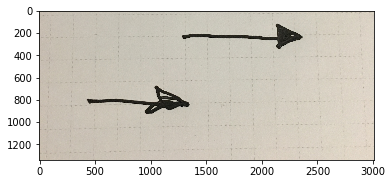

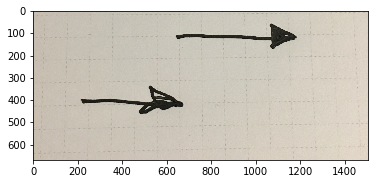

230


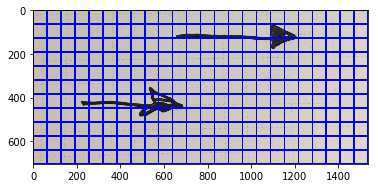

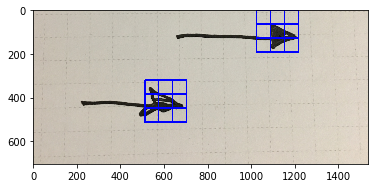

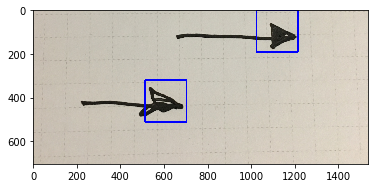

In [26]:
pipeline_vision_single(model, "test_data/3arrows copy 2.JPG", scale=2)